# Tennis Action Evaluator

## Introduction

### Problem

### Model Definition

#### State

#### Action

#### Rewards

### Data Processing

#### Raw Data

#### Extracted data

### Evaluation

We evaluate the model based on how well it estimates the actual probability that the agent at state $s$ performing action $a$ will win the rally.

We do this by passing a list of $(s,a)$ pairs to the estimator model to get the $Q(s,a)$ indicating the probability of the agent winning. Each $(s,a)$ pair has already been marked as belonging to the winner or the loser of the rally.

We deem a prediction correct in the following cases:
1. The $(s,a)$ pair belongs to the winner and gives a $Q(s,a) \ge 0.5$ 
2. The $(s,a)$ pair belongs to the loser and gives a $Q(s,a) \lt 0.5$

The final score of the model is calculated using $\frac{\text{correct predictions}}{\text{total predictions}}$.

## Approximated MC Learning

First, we tried a simple approximated MC learning to approximate the $Q(s,a)$ function as a baseline. This is a simple linear regression problem. We used `sklearn.linear_model.LinearRegression` to create an estimator model.

Since the reward of a tennis rally is only non-zero at the end of a rally, MC learning's behavior of looking at the accumulated rewards for an entire trial might be beneficial for estimating the Q-values of tennis actions.

### Training

Being that it is merely solving a system of linear equations, training of the estimator model is very quick for approximated MC learning.

In [1]:
import mc_learning as mc

mc_model = mc.train(save=False)
print(mc_model.coef_)

[[ 0.00046365  0.00620755  0.00934649 -0.02493163  0.0050135  -0.02148365
  -0.00191497 -0.00411411 -0.00643848  0.0220249  -0.00568214  0.02426598
   0.00129729 -0.00062967 -0.02203004  0.00634108 -0.00288176]]


### Evaluation

However, accuracy is low for this method, only correctly predicting the outcome of the $Q(s,a)$ correctly 53% of the time. The $Q(s,a)$ cannot be directly represented by a linear function of the features we have defined.

In [2]:
from data import test_dataset
import evaluation as eval

def mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = mc_model.predict(single_sample_reshape)
    return pred

score = eval.score_model(test_dataset, mc_predict)

print(f"Linear MC Learning Accuracy: {score}")

Linear MC Learning Accuracy: (0.5361596009975063, 0.24950967844844793)


## Deep Reinforcement Learning

### MC

#### Training

In [3]:
import d_sarsa

nn_mc_model, nn_mc_report = d_sarsa.train(save=False, use_mc=True)

EPOCH: 1.000  train_ave_loss: 0.256  train_ave_acc: 0.559  (3.16s - 471.30s remaining) ave_loss: 0.25645674109633715 ave_acc: 0.5594565770649821
EPOCH: 2.000  train_ave_loss: 0.244  train_ave_acc: 0.577  (6.01s - 444.59s remaining) ave_loss: 0.24393837292107842 ave_acc: 0.5773303593561897
EPOCH: 3.000  train_ave_loss: 0.241  train_ave_acc: 0.592  (8.82s - 432.41s remaining) ave_loss: 0.24149534621076588 ave_acc: 0.5917808652677172
EPOCH: 4.000  train_ave_loss: 0.238  train_ave_acc: 0.599  (11.65s - 425.38s remaining) ave_loss: 0.23760722816820717 ave_acc: 0.5990365064855825
EPOCH: 5.000  train_ave_loss: 0.235  train_ave_acc: 0.610  (14.49s - 420.08s remaining) ave_loss: 0.23484038635323648 ave_acc: 0.6096134332487414
EPOCH: 6.000  train_ave_loss: 0.230  train_ave_acc: 0.611  (17.26s - 414.30s remaining) ave_loss: 0.22984428684666883 ave_acc: 0.6111568687847124
EPOCH: 7.000  train_ave_loss: 0.224  train_ave_acc: 0.626  (20.06s - 409.83s remaining) ave_loss: 0.22432282222899175 ave_acc: 

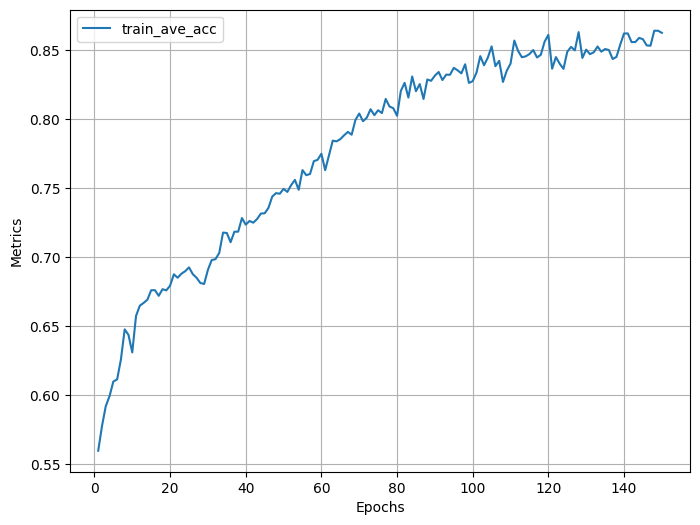

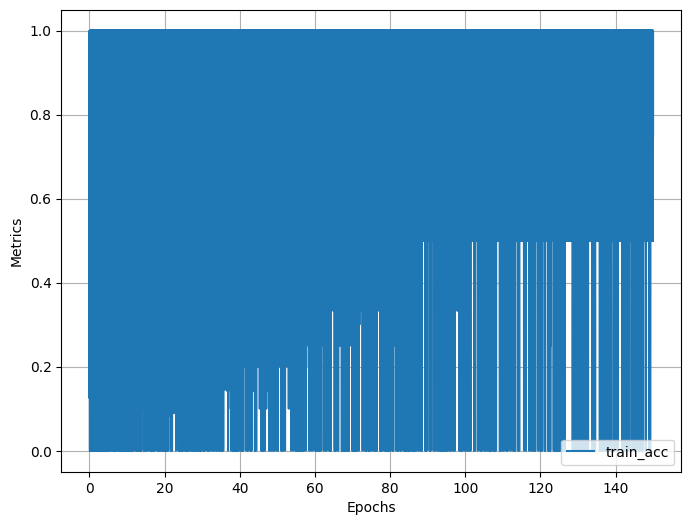

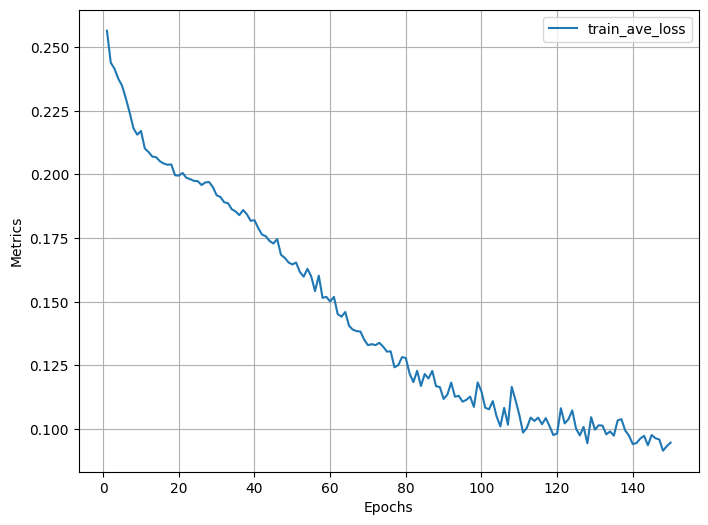

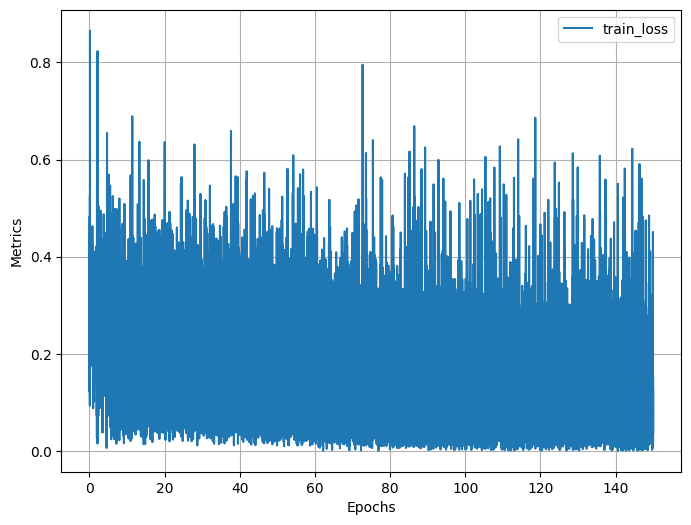

In [4]:
nn_mc_report.plot('train_ave_acc')
nn_mc_report.plot('train_acc')
nn_mc_report.plot('train_ave_loss')
nn_mc_report.plot('train_loss')

#### Evaluation

In [5]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_mc_model.eval()
def nn_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_mc_score, nn_mc_mse = eval.score_model(test_dataset, nn_mc_predict)

def nn_mc_predict_seq(sa_pair_seq):
    pred = nn_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_mc_seq_score, nn_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_mc_predict_seq)

print(f"NN MC Accuracy: {nn_mc_score}")
print(f"NN MC MSE: {nn_mc_mse}")
print(f"NN MC Seq Accuracy: {nn_mc_seq_score}")
print(f"NN MC Seq MSE: {nn_mc_seq_mse}")

NN MC Accuracy: 0.557356608478803
NN MC MSE: 0.32806713776451246
NN MC Seq Accuracy: 0.6122194513715711
NN MC Seq MSE: 0.3166984940298428


### SARSA

#### Training (Without MC Init)

In [6]:
import d_sarsa

nn_sarsa_model, nn_sarsa_report = d_sarsa.train(save=False, use_mc=False)

EPOCH: 1.000  train_ave_loss: 0.163  train_ave_acc: 0.510  (2.63s - 391.84s remaining) ave_loss: 0.1630222168136552 ave_acc: 0.5095973442251689
EPOCH: 2.000  train_ave_loss: 0.143  train_ave_acc: 0.519  (5.21s - 385.72s remaining) ave_loss: 0.14293655321613785 ave_acc: 0.5190010090029048
EPOCH: 3.000  train_ave_loss: 0.138  train_ave_acc: 0.523  (7.78s - 381.38s remaining) ave_loss: 0.13791812468276432 ave_acc: 0.5234967927966461
EPOCH: 4.000  train_ave_loss: 0.133  train_ave_acc: 0.541  (10.36s - 378.11s remaining) ave_loss: 0.13252118737313928 ave_acc: 0.540809177852896
EPOCH: 5.000  train_ave_loss: 0.133  train_ave_acc: 0.533  (12.93s - 374.97s remaining) ave_loss: 0.132561016778661 ave_acc: 0.533240654237881
EPOCH: 6.000  train_ave_loss: 0.127  train_ave_acc: 0.535  (15.50s - 372.03s remaining) ave_loss: 0.12655069174851316 ave_acc: 0.5354623118632748
EPOCH: 7.000  train_ave_loss: 0.113  train_ave_acc: 0.577  (18.24s - 372.52s remaining) ave_loss: 0.11256272523852387 ave_acc: 0.576

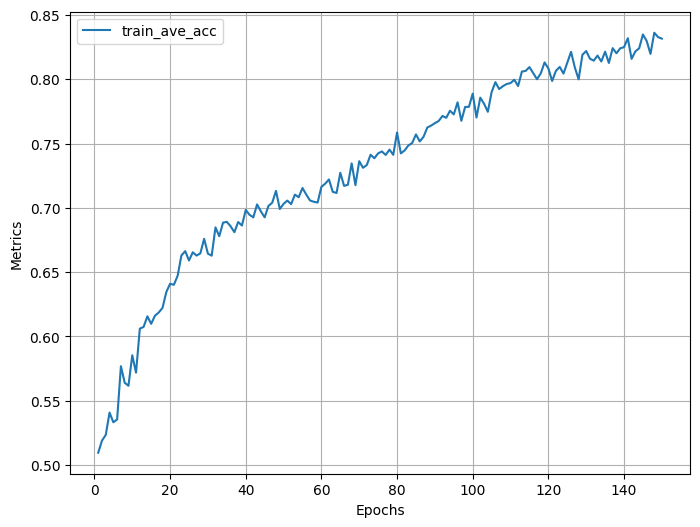

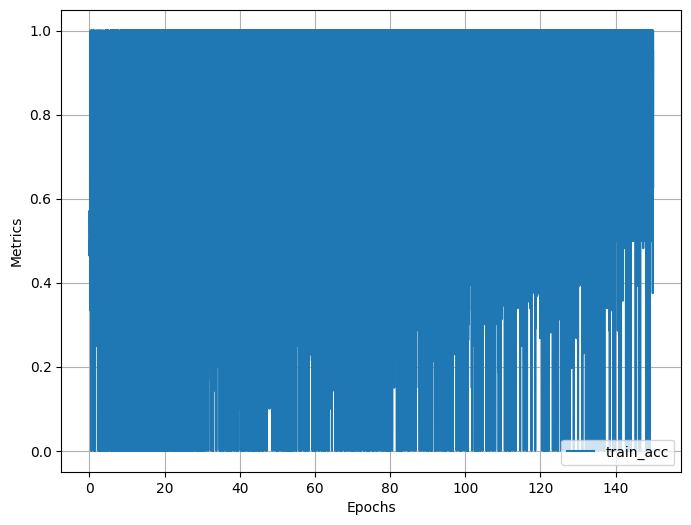

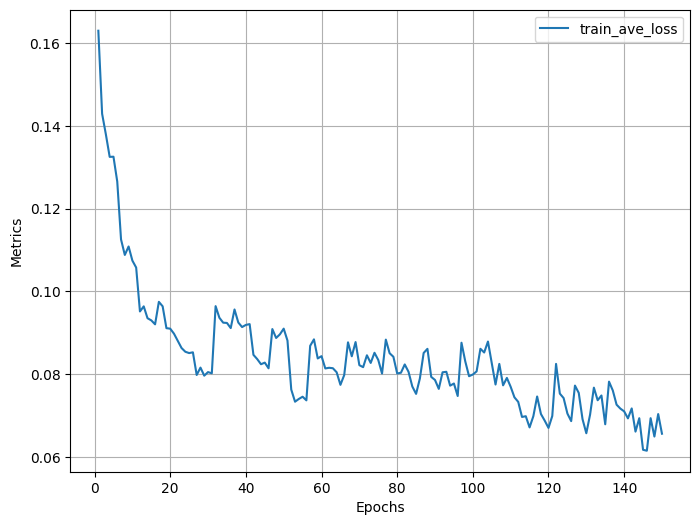

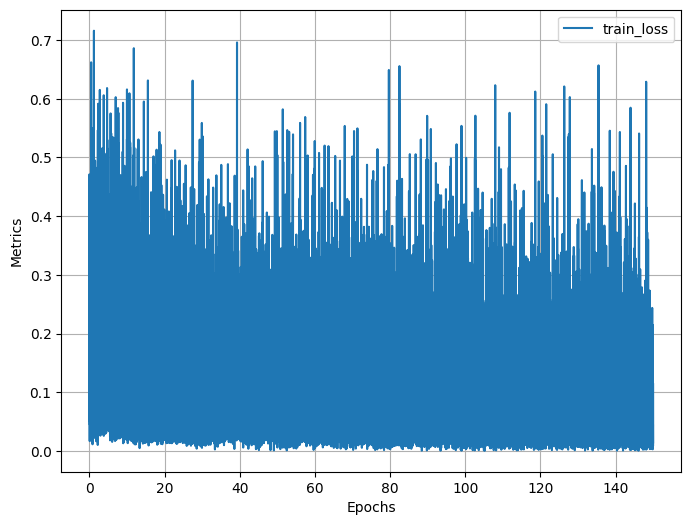

In [7]:
nn_sarsa_report.plot('train_ave_acc')
nn_sarsa_report.plot('train_acc')
nn_sarsa_report.plot('train_ave_loss')
nn_sarsa_report.plot('train_loss')

#### Evaluation (Without MC Init)

In [8]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_model.eval()
def nn_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_score, nn_sarsa_mse = eval.score_model(test_dataset, nn_predict)

def nn_predict_seq(sa_pair_seq):
    pred = nn_sarsa_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_seq_score, nn_sarsa_seq_mse = eval.score_model_sequential(test_dataset, nn_predict_seq)

print(f"NN Sarsa Accuracy: {nn_sarsa_score}")
print(f"NN Sarsa MSE: {nn_sarsa_mse}")
print(f"NN Sarsa Seq Accuracy: {nn_sarsa_seq_score}")
print(f"NN Sarsa Seq MSE: {nn_sarsa_seq_mse}")

NN Sarsa Accuracy: 0.57356608478803
NN Sarsa MSE: 0.29581949328723506
NN Sarsa Seq Accuracy: 0.6109725685785536
NN Sarsa Seq MSE: 0.2602142870324854


#### Training (With MC Init)

In [9]:
import d_sarsa

nn_mc_state_dict = nn_mc_model.state_dict()
nn_sarsa_with_mc_model, nn_sarsa_with_mc_report = d_sarsa.train(save=False, use_mc=False, init_state_dict=nn_mc_state_dict)

Init state dictionary was passed. Using that to initialize model_net.
EPOCH: 1.000  train_ave_loss: 0.077  train_ave_acc: 0.853  (2.51s - 374.01s remaining) ave_loss: 0.07728217680367731 ave_acc: 0.8529047493404176
EPOCH: 2.000  train_ave_loss: 0.067  train_ave_acc: 0.852  (5.01s - 370.61s remaining) ave_loss: 0.06684619801247334 ave_acc: 0.8520652545925836
EPOCH: 3.000  train_ave_loss: 0.072  train_ave_acc: 0.842  (7.49s - 366.91s remaining) ave_loss: 0.07201578303395915 ave_acc: 0.8415163062765617
EPOCH: 4.000  train_ave_loss: 0.066  train_ave_acc: 0.846  (9.96s - 363.51s remaining) ave_loss: 0.06638665457564759 ave_acc: 0.8461840682448329
EPOCH: 5.000  train_ave_loss: 0.065  train_ave_acc: 0.856  (12.51s - 362.86s remaining) ave_loss: 0.0646037672191607 ave_acc: 0.8557056269068839
EPOCH: 6.000  train_ave_loss: 0.064  train_ave_acc: 0.852  (15.08s - 361.84s remaining) ave_loss: 0.0641140983005729 ave_acc: 0.8516375638540238
EPOCH: 7.000  train_ave_loss: 0.073  train_ave_acc: 0.842  (

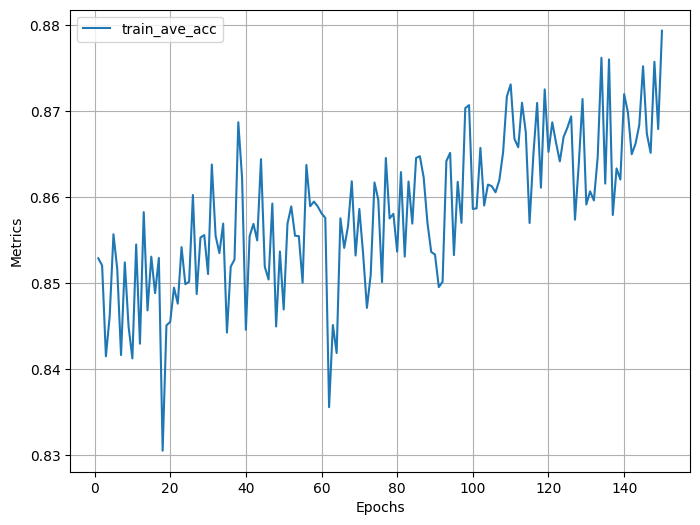

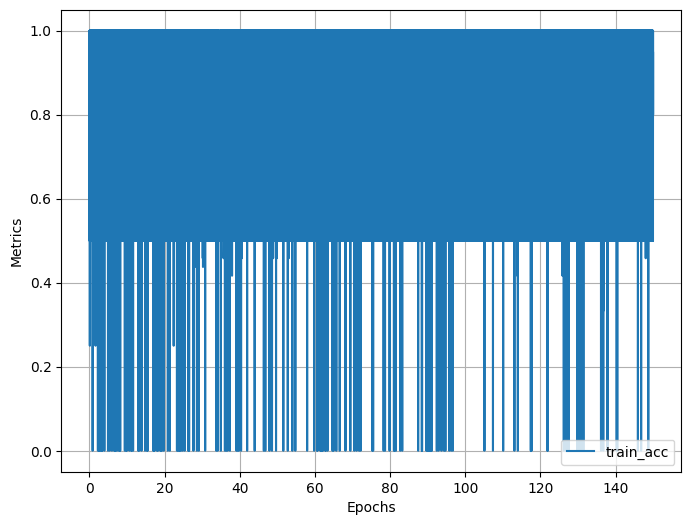

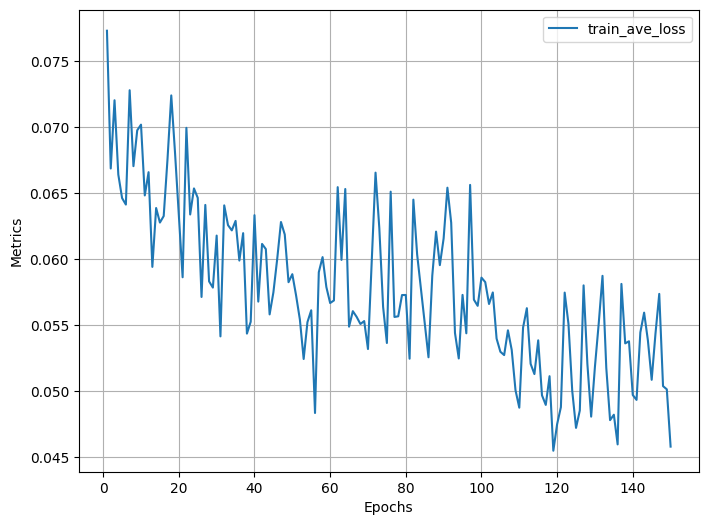

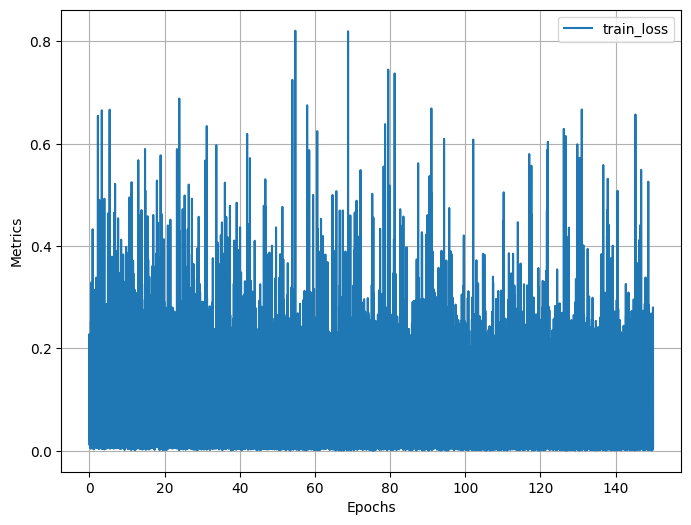

In [10]:
nn_sarsa_with_mc_report.plot('train_ave_acc')
nn_sarsa_with_mc_report.plot('train_acc')
nn_sarsa_with_mc_report.plot('train_ave_loss')
nn_sarsa_with_mc_report.plot('train_loss')

#### Evaluation (With MC Init)

In [11]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_with_mc_model.eval()
def nn_sarsa_with_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_with_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_with_mc_score, nn_sarsa_with_mc_mse = eval.score_model(test_dataset, nn_sarsa_with_mc_predict)

def nn_sarsa_with_mc_predict_seq(sa_pair_seq):
    pred = nn_sarsa_with_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_with_mc_seq_score, nn_sarsa_with_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_sarsa_with_mc_predict_seq)

print(f"NN Sarsa With MC Init Accuracy: {nn_sarsa_with_mc_score}")
print(f"NN Sarsa With MC Init MSE: {nn_sarsa_with_mc_mse}")
print(f"NN Sarsa With MC Init Seq Accuracy: {nn_sarsa_with_mc_seq_score}")
print(f"NN Sarsa With MC Init Seq MSE: {nn_sarsa_with_mc_seq_mse}")

NN Sarsa With MC Init Accuracy: 0.5498753117206983
NN Sarsa With MC Init MSE: 0.31176251628964463
NN Sarsa With MC Init Seq Accuracy: 0.600997506234414
NN Sarsa With MC Init Seq MSE: 0.31375569340077836


In [12]:
import os

model_dirpath = 'experiment_models/200epoch_e-2lr_vanilla_paper_params'
os.makedirs(model_dirpath, exist_ok=True)


torch.save(nn_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_mc_model.pth'))
torch.save(nn_sarsa_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_model.pth'))
torch.save(nn_sarsa_with_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_with_mc_model.pth'))

## Conclusion

### Summary

### Future extensions